In [2]:
#@title Implementação dos modelos em Python (*beta*)
#@markdown Esta célula contém a implementação em Python 3 dos principais modelos de computação vistos na disciplina de Linguagens Formais e Autômatos. 
#@markdown Não é necessário conhecer o código aqui implementado ou mesmo ter um conhecimento profundo da linguagem Python. Acompanhe os exemplos e experimente construir seus próprios modelos.
 
#@markdown >*Execute esta célula (`ctrl+enter` ou clicando no botão ao lado) para que o ambiente seja carregado com as classes implementadas.*
 
from graphviz import Digraph
import re
 
class AP: 
    def __init__(self, Q={}, Sigma={}, Gamma={}, delta={}, q0=0, F={}):
        self.states = Q
        self.inputAlphabet = Sigma
        self.stackAlphabet = Gamma
        self.transition = delta
        self.startState = q0
        self.acceptStates = F 
 
        self.initialize()
 
    def initialize(self, input_string=""):
        self.traces = [[(self.startState,tuple(input_string),())]]
 
    def check(self):
        pass
        
    def hasNext(self):
        return self.traces and (not self.acceptTraces())
    
    def acceptTraces(self):
        return [t for t in self.traces if t[-1][1] == () and t[-1][0] in self.acceptStates]
 
    def step(self):
        updated_traces = []
        for trace in self.traces:
          s, string, stack = trace[-1]
          A = {'', string[0]} if string else {''}
          B = {'', stack[-1]} if stack else {''}
          possible_transitions = [(s,a,b) for a in A for b in B if (s,a,b) in self.transition]          
          for (s,a,b) in possible_transitions:  
            for r,c in self.transition[s,a,b]:
              nstring = string[1:] if a else string
              nstack  = stack[:-1] if b else stack
              nstack  = nstack+(c,) if c else nstack
              if (not (r,nstring,nstack) in trace):
                updated_traces.append(trace+[(r,nstring,nstack)])
        self.traces = updated_traces
 
    def run(self, input_string=0, max_steps=1000):        
        while (self.hasNext()): 
          if max_steps == 0: 
            raise Exception("Timeout")
          self.step()
          max_steps -= 1
        return self.result()
 
    def aceita(self, input_string=0):
        self.initialize(input_string)
        return self.run()
 
    def result(self):
        return True if self.acceptTraces() else (False if (not self.traces) else None)
    
    def visualizar(self):      
        f = Digraph('finite_state_machine', filename='fsm.gv')
        f.attr(rankdir='LR', size='8,5')
 
        f.attr('node', shape='point')
        f.node('')
        
        f.attr('node', shape='doublecircle')
        for n in self.acceptStates:
          f.node(str(n))
 
        f.attr('node', shape='circle')
        for n in self.states.difference(self.acceptStates):
          f.node(str(n))
 
        label = {}        
        for (q,a,b) in self.transition:
          for (r,c) in self.transition[q,a,b]:          
            label[q,r] = label[q,r]+[(a,b,c)] if (q,r) in label else [(a,b,c)]
 
        f.edge('', str(self.startState))
        for (q,r) in label:
          f.edge(str(q),str(r),label=self.graphviz_edge_label_format(label[q,r]))      
          pass
        
        return f
    
    def graphviz_edge_label_format(self,labels=[]):
        epsilon = "\u03BB"
        right_arrow = "\u2192"
        return '\n'.join([(a if (a or a==0) else epsilon) + "," + (b if (b or b==0) else epsilon) + right_arrow + (c if (c or c==0) else epsilon) for (a,b,c) in labels])
        # return '\n'.join([(str(a) if a else epsilon) + "," + (str(b) if b else epsilon) + right_arrow + (str(c) if c else epsilon) for (a,b,c) in labels])
 
class AFN(AP):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_pda = {}
        for q,a in delta:
          delta_pda[q,a,''] = {(r,'') for r in delta[q,a]}
        super().__init__(Q,Sigma,{},delta_pda,q0,F)
  
  def graphviz_edge_label_format(self,labels):
      epsilon = "\u03BB"
      return ",".join([(str(a) if (a or a==0) else epsilon) for (a,b,c) in labels])
 
class AFD(AFN):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_nfa = {}
        for (q,a) in delta:
          delta_nfa[q,a] = {delta[q,a]}
        super().__init__(Q,Sigma,delta_nfa,q0,F)
 
class ER:
  def __init__(self,regex=None):  
    if (regex == None):
      self.regex = None
    elif (re.match("^[a-zA-Z0-9\(\)\|\*]*$", regex)):
      self.regex = regex
    else:
      raise Exception("Invalid pattern")
 
  def gera(self, input_string):
    if (self.regex == None):
      return False
    else:
      return True if re.match("^"+self.regex+"$",input_string) else False
 
class GLC:
  def __init__(self,V,Sigma,R,S):
      self.variables = V
      self.terminals = Sigma
      # self.rules = R
      self.rules = {(a, tuple(b)) for (a,b) in R}
      self.start = S
 
      self.derivation = []
      self.chomsky = None
  
  def gera(self, string):
      if (not self.chomsky):
        self.chomsky = self.to_chomsky()        
      G = self.chomsky
      
      if len(string) == 0: return (G.start,()) in G.rules
 
      # CYK Algorithm
      n = len(string)
      P = [[[] for x in range(n - y)] for y in range(n)]
      for i,c in enumerate(string):
        for v in [a for (a,b) in G.rules if len(b) == 1 and c in b]:
          P[0][i] += [v]
      for l in range(2, n+1): # borda da iteração
        for s in range(0, n+1-l): # coluna
          for p in range(1, l): # linha
            for u, v in [(a,b) for (a,b) in G.rules if len(b) == 2]:
              if v[0] in P[p-1][s] and v[1] in P[l-p-1][s+p]:
                P[l-1][s] += [u]
      return G.start in P[-1][0]
 
  def print(self):
      rightarrow = "\u2192"
      print(self.start,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == S]))
      for v in sorted(self.variables.difference(self.start)): 
        print(v,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == v]))
 
  def replace_eps(self, v, l):
    if not l: return {()}
    result = {(l[0],) + s for s in self.replace_eps(v, tuple(l[1:]))}
    if l[0] == v:
      result.update({tuple(s[1:]) for s in result})
    return result   
 
  def to_chomsky(self):
      n_state = 0
      
      S = '<{}>'.format(n_state)
      Sigma = self.terminals 
      V = {S}.union(self.variables)
      R = {(S,(self.start,))}.union(self.rules)
 
      target = {alpha for alpha in self.variables if (alpha,()) in R}
      while (target):
        for e in target:
          rules = {(alpha,beta) for (alpha,beta) in R if e in beta}
          for (a,b) in rules:
            R.update({(a, beta) for beta in self.replace_eps(e,b)})
          R.discard((e,()))
        target = {alpha for alpha in self.variables if (alpha,()) in R}
      
      target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      while (target):
        for u,v in target:
          rules = {b for (a,b) in R if a == v[0]}
          R.update({(u,b) for b in rules})
          R.discard((u,v))
        target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
      while(target):
        for u,v in target:
          n_state += 1
          state = '<{}>'.format(n_state)
          V.update({state})
          R.update({(u,(v[0],state)),(state, tuple(v[1:]))})
          R.discard((u,v))
        target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
 
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) == 2}
      for u,v in target:
        n = list(v)
        for i in range(2):
          if v[i] in Sigma:
            R.discard((u,(n[0],n[1])))
            n_state += 1
            n[i] = '<{}>'.format(n_state)
            V.update({n[i]})
            R.update({(u,(n[0],n[1]))})
            R.update({(n[i],(v[i],))})
 
      return GLC(V,Sigma,R,S)

In [3]:
#@title # Contrução de árvores de derivação com NetworkX
#@markdown Esta célula contém uma implementação em Python3 da função que organiza os vértices da árvore de derivação de forma hierárquica. 
#@markdown >*Execute esta célula (`ctrl+enter` ou clicando no botão ao lado) para que a função seja carregada.*
import networkx as nx
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

###Exemplo
Seja a gramática $G = (\{E\}, \{t, +, ∗, (, )\}, R, E)$, para expressões aritméticas, onde $R$ consta das regras:
$$
E \rightarrow E+E \mid E*E \mid (E) \mid t
$$
Tal gramática é ambígua, já que existem duas Árvores de Derivação da palavra $t+t+t$, as quais estão mostradas abaixo.

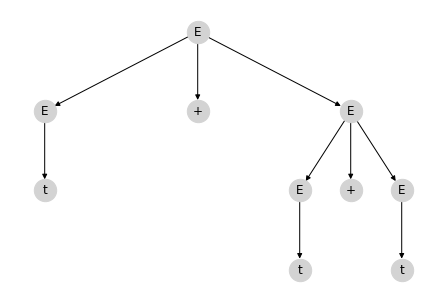

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

D=nx.DiGraph()
D.add_edges_from([(0,1),(0,2),(0,3),(1,4),(3,5),(3,6),(3,7),(5,8),(7,9)])
posD = hierarchy_pos(D,0)    

nx.draw(D, posD, node_size=500,node_color='lightgray')

labelD = {}
labelD[0] = 'E'
labelD[1] = 'E'
labelD[2] = '+'
labelD[3] = 'E'
labelD[4] = 't'
labelD[5] = 'E'
labelD[6] = '+'
labelD[7] = 'E'
labelD[8] = 't'
labelD[9] = 't'
nx.draw_networkx_labels(D, posD, labelD)

plt.axis("off")
plt.show()

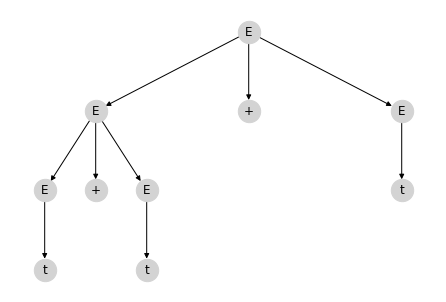

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

E=nx.DiGraph()
E.add_edges_from([(0,1),(0,2),(0,3),
                  (1,4),(1,5),(1,6),(3,7),
                  (4,8),(6,9)])

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'E'
labelE[1] = 'E'
labelE[2] = '+'
labelE[3] = 'E'
labelE[4] = 'E'
labelE[5] = '+'
labelE[6] = 'E'
labelE[7] = 't'
labelE[8] = 't'
labelE[9] = 't'
nx.draw_networkx_labels(E, posE, labelE)

plt.axis("off")
plt.show()


# Exercícios

1. Construa uma GLC para a linguagem $\{a^mb^nc^{3m+2n+1} \mid m, n \geq 0\}$. 


In [ ]:
V = {'A', 'B'}
Sigma = {'a', 'b', 'c'}
R = {
  ('A', 'aAccc'),
  ('A', 'B'),
  ('B', 'bBcc'),
  ('B', 'c'),
}
S = 'A'

G = GLC(V,Sigma,R,S)

G.print()
print()

# true
print(G.gera('aabbbccccccccccccc'))
print(G.gera('abcccccc'))
print(G.gera('abbcccccccc'))
print(G.gera('bccc'))
print(G.gera('acccc'))
print(G.gera('c'))

# false
print(G.gera(''))
print(G.gera('bcc'))
print(G.gera('aacccccc'))

A → aAccc|B
B → c|bBcc

True
True
True
True
True
True
False
False
False


2. Construa uma GLC para a linguagem $\{a^nb^{2n+k}c^{3k} \mid n, k \geq 0\}$.

In [ ]:
V = {'P', 'A', 'C'}
Sigma = {'a', 'b', 'c'}
R = {
  ('P', 'aAbbC'),
  ('P', 'C'),
  ('A', 'aAbb'),
  ('A', ''),
  ('C', 'bCccc'),
  ('C', ''),
}
S = 'P'

G = GLC(V,Sigma,R,S)

G.print()
print()

# true
print(G.gera('aabbbbbccc'))
print(G.gera('abbbbcccccc'))
print(G.gera('aaabbbbbb'))
print(G.gera('bbbccccccccc'))
print(G.gera(''))

# false
print(G.gera('aabbbbb'))
print(G.gera('abbb'))
print(G.gera('aacccccc'))

P → C|aAbbC
A → |aAbb
C → bCccc|

True
True
True
True
True
False
False
False


3. Dada a seguinte gramática, mostre duas derivações à esquerda diferentes para a plavra $aabbccdd$

\begin{align}
S &\rightarrow AB \mid C\\
A &\rightarrow  aAb \mid ab\\
B &\rightarrow  cBd \mid  cd\\
C &\rightarrow  aCd \mid  aDd\\
D &\rightarrow  bDc \mid  bc
\end{align}

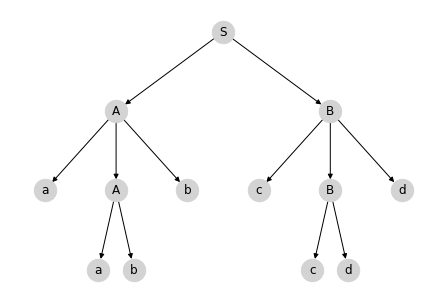

In [8]:
E=nx.DiGraph()
E.add_edges_from(
  [
    (0,1),(0,2),
    (1,3),(1,4),(1,5),
    (2,6),(2,7),(2,8),
    (4,9),(4,10),
    (7,11),(7,12),
  ]
)

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'S'
labelE[1] = 'A'
labelE[2] = 'B'
labelE[3] = 'a'
labelE[4] = 'A'
labelE[5] = 'b'
labelE[6] = 'c'
labelE[7] = 'B'
labelE[8] = 'd'
labelE[9] = 'a'
labelE[10] = 'b'
labelE[11] = 'c'
labelE[12] = 'd'

nx.draw_networkx_labels(E, posE, labelE)

plt.axis("off")
plt.show()

Arvóre de derivação mais a esqueda


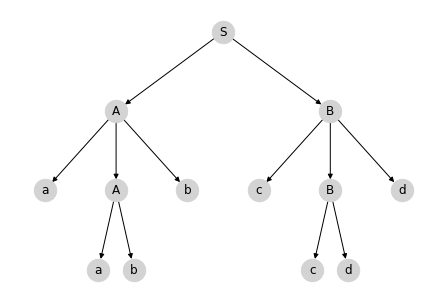

In [10]:
E=nx.DiGraph()
E.add_edges_from(
  [
    (0,1),(0,2),
    (1,3),(1,4),(1,5),
    (2,6),(2,7),(2,8),
    (4,9),(4,10),
    (7,11),(7,12),
  ]
)

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'S'
labelE[1] = 'A'
labelE[2] = 'B'
labelE[3] = 'a'
labelE[4] = 'A'
labelE[5] = 'b'
labelE[6] = 'c'
labelE[7] = 'B'
labelE[8] = 'd'
labelE[9] = 'a'
labelE[10] = 'b'
labelE[11] = 'c'
labelE[12] = 'd'

nx.draw_networkx_labels(E, posE, labelE)

print("Arvóre de derivação mais a esqueda")

plt.axis("off")
plt.show()

Arvóre de derivação mais a direita


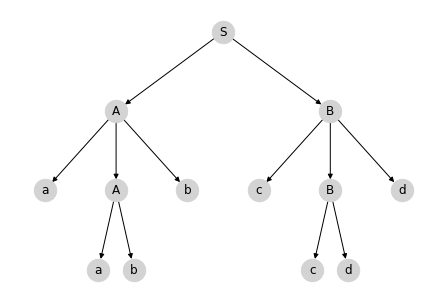

In [9]:
E=nx.DiGraph()
E.add_edges_from(
  [
    (0,1),(0,2),
    (1,3),(1,4),(1,5),
    (2,6),(2,7),(2,8),
    (4,9),(4,10),
    (7,11),(7,12),
  ]
)

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'S'
labelE[1] = 'A'
labelE[2] = 'B'
labelE[3] = 'a'
labelE[4] = 'A'
labelE[5] = 'b'
labelE[6] = 'c'
labelE[7] = 'B'
labelE[8] = 'd'
labelE[9] = 'a'
labelE[10] = 'b'
labelE[11] = 'c'
labelE[12] = 'd'

nx.draw_networkx_labels(E, posE, labelE)

print("Arvóre de derivação mais a direita")

plt.axis("off")
plt.show()

4. Mostre que a gramática $G=(\{P,S,C,V\},\{l,b,x,u,a\},R,P)$, com o conjunto de regras $R$ definido abaixo, é ambígua.

\begin{align}
		P & \rightarrow SP  \mid S  ~|~ \lambda\\
		S & \rightarrow CCV \mid CV ~|~ CCVV ~|~ V ~|~ VC ~|~ CVC ~|~ VV ~|~ CVV\\
		C & \rightarrow l \mid b ~|~ x\\
		V & \rightarrow u \mid a 
\end{align}

Pois, como é provado a seguir, a palavra 'uu' pode ser obtiva através de duas árvores de derivação diferentes.

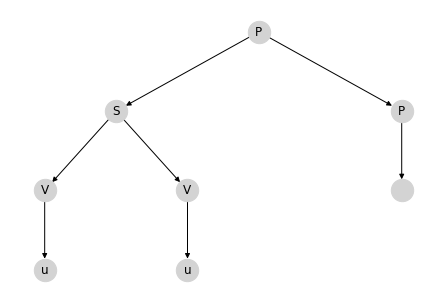

In [12]:
E=nx.DiGraph()
E.add_edges_from(
  [
    (0,1),(0,2),
    (1,3),(1,4),
    (2,5),
    (3,6),
    (4,7),
  ]
)

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'P'
labelE[1] = 'S'
labelE[2] = 'P'
labelE[3] = 'V'
labelE[4] = 'V'
labelE[5] = ''
labelE[6] = 'u'
labelE[7] = 'u'

nx.draw_networkx_labels(E, posE, labelE)

plt.axis("off")
plt.show()

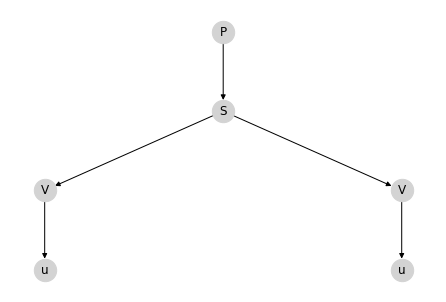

In [13]:
E=nx.DiGraph()
E.add_edges_from(
  [
    (0,1),
    (1,2),(1,3),
    (2,4),
    (3,5),
  ]
)

posE = hierarchy_pos(E,0)  
  
nx.draw(E, posE, node_size=500,node_color='lightgray')

labelE = {}
labelE[0] = 'P'
labelE[1] = 'S'
labelE[2] = 'V'
labelE[3] = 'V'
labelE[4] = 'u'
labelE[5] = 'u'

nx.draw_networkx_labels(E, posE, labelE)

plt.axis("off")
plt.show()